In [1]:
# Importing libraries and packages
import geopandas as gpd
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn import metrics

# Save models
import pickle

In [2]:
# Display Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Random Forest Model trained on Fema Large without Outliers, without rentalAssistanceAmount

### Load the Training and Test Datasets - FL/TX and PR

In [3]:
femaTrainData = pd.read_csv('../../data/open-fema/experimental/FEMA-Large-Demographics-FL-TX-clean.csv')
print('There are {} records in our training dataset.'.format(len(femaTrainData)))

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 3534888 records in our training dataset.


In [4]:
femaTrainData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'below_poverty_rate',
       'median_earnings_total', 'une

In [134]:
femaTestData = pd.read_csv('../../data/open-fema/experimental/FEMA-Large-Demographics-PR-clean.csv')
print('There are {} records in our test dataset.'.format(len(femaTestData)))

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1067001 records in our test dataset.


In [135]:
femaTestData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'below_poverty_rate',
       'median_earnings_total', 'une

### Define a subset of columns

IHP: https://docs.google.com/document/d/1nu0yENGAWnoiMcTufxYnH7xwdh8NfFum9ni9IYiSIdk/edit#

Demographics: https://docs.google.com/document/d/1cpznnaIb5CE21I2RO8y2xRvZKS8StcP_JeXDW2mUIis/edit?ts=60319d34#heading=h.j8u0tgugtaw

In [7]:
ihp_exclude_cols = ['disasterNumber', 
                    'damagedCity', 
                    'damagedStateAbbreviation',
                    'damagedZipCode',
                    'grossIncome',
                    'foundationDamageAmount',
                    'roofDamageAmount',
                    'tsaCheckedIn',
                    'rentalAssistanceAmount',
                    'rentalAssistanceEligible',
                    'repairAmount',
                    'replacementAmount',
                    'renterDamageLevel', 
                    'rentalAssistanceEndDate', 
                    'rentalResourceCity',
                    'rentalResourceStateAbbreviation', 
                    'rentalResourceZipCode',
                    'personalPropertyEligible', 
                    'ppfvl',
                    'censusBlockId', 
                    'censusYear', 
                    'id']
demo_exclude_cols = ['censusTractId', 
                     'censusid',
                     'tractid', 
                     'tractname', 
                     'county', 
                     'state',
                     'median_earnings_total',]
demo_dvi_col = ['dvi']
demo_rate_cols = ['below_poverty_rate',
                  'unemployed_labor_rate',
                  'built_1979_or_earlier_rate', 
                  'owner_occupied_rate']

### RandomForest

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [8]:
def run_rf(df, frac, max_depth, max_samples, n_estimators, min_samples_leaf):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42) 
  
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # Define the model
    model_rf = RandomForestRegressor(max_depth = max_depth, max_samples = max_samples, n_estimators = n_estimators, 
                                     min_samples_leaf = min_samples_leaf, random_state = 42)
    
    # Fit the model
    model_rf.fit(X_train, y_train)
    
    return (model_rf, model_rf.predict(X_test), y_test)

In [9]:
def run_rf_grid_search(df, frac, scoring):
    # Sample the dataset
    df_train = df.sample(frac=frac) if frac < 1.0 else df    
        
    # Create test/train split
    X = df_train.loc[:, df_train.columns != 'haAmount']
    y = df_train.loc[:, 'haAmount']    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
    
    print('Shape of Training and Test inputs')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    # RandomForestRegressor default model
    model_rf = RandomForestRegressor(random_state = 42)
    
    # Create the parameter grid
    param_grid_rf = {
        'bootstrap': [True],
        'max_samples': [0.8, 0.9, None],
        'max_depth': [8, 9, 10],
        'n_estimators': [75, 100, 125],
        'min_samples_leaf': [1, 5, 10]
    }
    
    # Instantiate the grid search model
    grid_search_rf = GridSearchCV(estimator = model_rf, param_grid = param_grid_rf, 
                                  scoring = scoring, cv = 3, n_jobs = -1, verbose = 2)
    
    # Fit the grid search to the data
    grid_search_rf.fit(X_train, y_train)
    
    print('Best params:\n', grid_search_rf.best_params_)
    
    # Predict using best model
    model_rf_best = grid_search_rf.best_estimator_
    
    return (model_rf_best, model_rf_best.predict(X_test), y_test)

In [10]:
def evaluate(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-squared:', metrics.r2_score(y_test, y_pred))
    print('\n')
    print('Total HA Amount actual:    ${:,.2f}'.format(y_test.sum()))
    print('Total HA Amount predicted: ${:,.2f}'.format(y_pred.sum()))
    print('\n')
    
    # Calculate the number of observations that are off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('Percentage of predictions that are off by more than 20%: {:.2f}'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))   

In [11]:
def predict(df, model):
    X_test = df.loc[:, df.columns != 'haAmount']
    y_test = df.loc[:, 'haAmount']    
  
    print('Shape of Training and Test inputs')    
    print(X_test.shape, y_test.shape)
    
    return (model.predict(X_test), y_test)  

### Create IHP-only Train and Test Datasets

In [15]:
femaTrainDf = femaTrainData[femaTrainData.columns[~femaTrainData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [27]:
femaTrainDf.columns

Index(['householdComposition', 'specialNeeds', 'homeOwnersInsurance',
       'floodInsurance', 'inspected', 'rpfvl', 'habitabilityRepairsRequired',
       'destroyed', 'waterLevel', 'floodDamage', 'foundationDamage',
       'roofDamage', 'tsaEligible', 'repairAssistanceEligible',
       'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence',
       'haAmount', 'ownRent_Owner', 'ownRent_Renter', 'ownRent_Unknown',
       'residenceType_Apartment', 'residenceType_Assisted Living Facility',
       'residenceType_Boat', 'residenceType_College Dorm',
       'residenceType_Condo', 'residenceType_Correctional Facility',
       'residenceType_House/Duplex', 'residenceType_Military Housing',
       'residenceType_Mobile Home', 'residenceType_Other',
       'residenceType_Townhouse', 'residenceType_Travel Trailer',
       'residenceType_Unknown'],
      dtype='object')

In [13]:
femaTestDf = femaTestData[femaTestData.columns[~femaTestData.columns.isin(
    ihp_exclude_cols + demo_exclude_cols + demo_dvi_col + demo_rate_cols)]]

In [28]:
femaTestDf.columns

Index(['householdComposition', 'specialNeeds', 'homeOwnersInsurance',
       'floodInsurance', 'inspected', 'rpfvl', 'habitabilityRepairsRequired',
       'destroyed', 'waterLevel', 'floodDamage', 'foundationDamage',
       'roofDamage', 'tsaEligible', 'repairAssistanceEligible',
       'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence',
       'haAmount', 'ownRent_Owner', 'ownRent_Renter', 'ownRent_Unknown',
       'residenceType_Apartment', 'residenceType_Assisted Living Facility',
       'residenceType_Boat', 'residenceType_College Dorm',
       'residenceType_Condo', 'residenceType_Correctional Facility',
       'residenceType_House/Duplex', 'residenceType_Military Housing',
       'residenceType_Mobile Home', 'residenceType_Other',
       'residenceType_Townhouse', 'residenceType_Travel Trailer',
       'residenceType_Unknown'],
      dtype='object')

### Grid Search
Parameter Grid:

    param_grid_rf = {
        'bootstrap': [True],
        'max_samples': [0.8, 0.9, None],
        'max_depth': [8, 9, 10],
        'n_estimators': [75, 100, 125],
        'min_samples_leaf': [1, 5, 10]
    }
    
Grid Search Params:

    scoring='neg_mean_squared_error'
    cv = 3    

In [17]:
model_rf_best, y_pred, y_test = run_rf_grid_search(femaTrainDf, frac = 1.0, scoring = 'neg_mean_squared_error')

Shape of Training and Test inputs
(2827910, 33) (2827910,)
(706978, 33) (706978,)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best params:
 {'bootstrap': True, 'max_depth': 9, 'max_samples': 0.8, 'min_samples_leaf': 5, 'n_estimators': 125}


In [18]:
evaluate(y_test, y_pred)

Mean Absolute Error: 26.7803822903206
Mean Squared Error: 188147.74399838116
Root Mean Squared Error: 433.76000737548543
R-squared: 0.9622043125642697


Total HA Amount actual:    $221,268,210.44
Total HA Amount predicted: $221,320,822.97


Percentage of predictions that are off by more than 20%: 0.94


In [19]:
# Look at the distribution of predictions/actuals/errors
results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results_df['errors'] = results_df['predicted'] - results_df['actual']
results_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
actual,706978.0,312.977505,2231.149597,0.000000,0.0,0.0,0.0,33300.000000
predicted,706978.0,313.051924,2185.125245,0.000000,0.0,0.0,0.0,31024.726161
errors,706978.0,0.074419,433.760308,-32106.262813,0.0,0.0,0.0,29747.467553


In [21]:
# Save the model
pickle.dump(model_rf_best, open('./models/random_forest.sav', 'wb'))

In [22]:
# Load saved model
model_rf_sav = pickle.load(open('./models/random_forest.sav', 'rb'))
model_rf_sav.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 125,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### RandomForest Model - Hyperparameters based on grid search
    max_depth = 9, max_samples = 0.8, n_estimators = 125, 
    min_samples_leaf = 5, random_state = 42

In [23]:
model_rf, y_pred, y_test = run_rf(femaTrainDf, frac = 1.0, max_depth = 9, max_samples = 0.8, 
                                  n_estimators = 125, min_samples_leaf = 5)

Shape of Training and Test inputs
(2827910, 33) (2827910,)
(706978, 33) (706978,)


In [24]:
evaluate(y_test, y_pred)

Mean Absolute Error: 26.7803822903206
Mean Squared Error: 188147.74399838116
Root Mean Squared Error: 433.76000737548543
R-squared: 0.9622043125642697


Total HA Amount actual:    $221,268,210.44
Total HA Amount predicted: $221,320,822.97


Percentage of predictions that are off by more than 20%: 0.94


In [25]:
results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results_df['errors'] = results_df['predicted'] - results_df['actual']
results_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
actual,706978.0,312.977505,2231.149597,0.000000,0.0,0.0,0.0,33300.000000
predicted,706978.0,313.051924,2185.125245,0.000000,0.0,0.0,0.0,31024.726161
errors,706978.0,0.074419,433.760308,-32106.262813,0.0,0.0,0.0,29747.467553


In [26]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 125,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Predict on Test (PR) using RandomForest Model

In [128]:
y_pred, y_test = predict(femaTestDf, model_rf)

Shape of Training and Test inputs
(1067001, 33) (1067001,)


In [129]:
evaluate(y_test, y_pred)

Mean Absolute Error: 46.47816469336652
Mean Squared Error: 187023.9848660589
Root Mean Squared Error: 432.4626976584904
R-squared: 0.9679136599626932


Total HA Amount actual:    $529,464,356.32
Total HA Amount predicted: $530,317,226.34


Percentage of predictions that are off by more than 20%: 2.60


In [130]:
results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results_df['errors'] = results_df['predicted'] - results_df['actual']
results_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
actual,1067001.0,496.21730093974776,2414.28627661572,0.0,0.0,0.0,0.0,33300.0
predicted,1067001.0,497.0166160467901,2359.5719088403844,0.0,0.0,0.0,0.0,30802.669319655488
errors,1067001.0,0.7993151071627294,432.4621616324008,-31463.948668510384,0.0,0.0,0.0,28590.764088485856


### Generate Prediction Files using RandomForest Model predictions

In [136]:
# Append predictions to femaTestData
femaTestData['haAmount_predicted'] = y_pred

In [137]:
femaTestData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'below_poverty_rate',
       'median_earnings_total', 'une

In [138]:
# Drop demographics from FEMA file
femaTestData.drop(['below_poverty_rate', 'unemployed_labor_rate', 'median_earnings_total',
                                   'built_1979_or_earlier_rate', 'owner_occupied_rate', 'dvi'], axis=1, inplace=True)
                            
femaTestData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'censusid',
       'tractid', 'tractname', 'county', 'state', 'haAmount', 'ownRent_Owner',
       'ownRent_Renter', 'own

### Combine Demographics with PR Predictions (GisJoin)

In [139]:
# Load demographics data
demoDf = pd.read_csv("../../data/census-tract/census-tract-demographics.csv")

In [140]:
# Select subset of variables
demoDf = demoDf[['tractid', 'gisjoin']]
demoDf.head(3)

,tractid,gisjoin
0,12001000200,G1200010000200
1,12001000301,G1200010000301
2,12001000302,G1200010000302


In [141]:
# Merge predictions with demographics - need GISJOIN for Tableau visualizations
femaTestData = pd.merge(femaTestData, demoDf, left_on='censusTractId', right_on='tractid')

# Remove common join column
femaTestData = femaTestData.drop(['tractid_y'], axis=1)

### Create Prediction Files

In [142]:
# Write predictions
femaTestData.to_csv("./predictions/FEMA-Large-PR-predictions.csv", index=False, encoding='utf-8')

In [45]:
# Write predictions - zipped
femaTestData.to_csv("./predictions/FEMA-Large-PR-predictions.csv.gz", index=False, encoding='utf-8', compression='gzip')

In [117]:
# Rollup aggregations to censusTractId
femaTestData_CensusTract = femaTestData.groupby(['censusTractId', 'gisjoin']).agg({
                                           'id': ['count'], 
                                           'grossIncome': ['mean'],
                                           'householdComposition': ['mean'],                                           
                                           'specialNeeds': ['sum'], 
                                           'homeOwnersInsurance': ['sum'],
                                           'floodInsurance': ['sum'],
                                           'inspected': ['sum'],
                                           'rpfvl': ['sum'],
                                           'habitabilityRepairsRequired': ['sum'],
                                           'destroyed': ['sum'],
                                           'waterLevel': ['mean'],
                                           'floodDamage': ['sum'],
                                           'foundationDamage': ['sum'], 
                                           'foundationDamageAmount': ['sum'], 
                                           'roofDamage': ['sum'],
                                           'roofDamageAmount': ['sum'], 
                                           'tsaEligible': ['sum'], 
                                           'tsaCheckedIn': ['sum'],
                                           'rentalAssistanceEligible': ['sum'], 
                                           'rentalAssistanceAmount': ['sum'], 
                                           'repairAssistanceEligible': ['sum'],
                                           'repairAmount': ['sum'],
                                           'replacementAssistanceEligible': ['sum'], 
                                           'replacementAmount': ['sum'], 
                                           'sbaEligible': ['sum'],
                                           'primaryResidence': ['sum'], 
                                           'personalPropertyEligible': ['sum'], 
                                           'ppfvl': ['sum'],
                                           'haAmount': ['sum'],
                                           'haAmount_predicted': ['sum']
                                          }).round(2).reset_index()

In [118]:
pd.set_option('display.float_format', str)
femaTestData_CensusTract.head(20)

,censusTractId,gisjoin,id,grossIncome,householdComposition,specialNeeds,homeOwnersInsurance,floodInsurance,inspected,rpfvl,habitabilityRepairsRequired,destroyed,waterLevel,floodDamage,foundationDamage,foundationDamageAmount,roofDamage,roofDamageAmount,tsaEligible,tsaCheckedIn,rentalAssistanceEligible,rentalAssistanceAmount,repairAssistanceEligible,repairAmount,replacementAssistanceEligible,replacementAmount,sbaEligible,primaryResidence,personalPropertyEligible,ppfvl,haAmount,haAmount_predicted
,,,count,mean,mean,sum,sum,sum,sum,sum,sum,sum,mean,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
0,12099007201,G1200990007201,1,2000.0,4.0,0,0,0,1,21523.41,1,0,0.0,0,0,0.0,1,1920.0,1,1.0,1,1080.0,1,21523.41,0,0.0,0,1,1.0,14819.02,21523.41,21531.89
1,12103026601,G1201030026601,1,69800.0,1.0,0,0,0,1,0.0,1,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,1,0.0,0.0,0.0,0.0
2,12105012503,G1201050012503,1,20000.0,1.0,0,0,0,1,0.0,0,0,0.0,0,0,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0
3,72001956300,G7200010956300,3036,23877.83,2.34,73,124,14,2202,6297242.05,2091,27,0.12,44,52,86689.77,741,876777.02,2773,28.0,533,441944.0,689,2788698.19,18,545495.04,101,2926,878.0,2604425.11,3334193.23,3298882.55
4,72001956400,G7200010956400,35,36590.36,2.14,0,0,1,27,44463.88,22,0,0.4,2,2,5011.97,10,11940.6,32,0.0,7,5592.0,11,39423.41,0,0.0,0,32,18.0,37541.08,39423.41,43341.39
5,72001956500,G7200010956500,122,13109.69,2.37,4,2,1,87,264345.62,88,1,0.87,4,1,1117.03,36,38054.12,104,1.0,29,26251.0,36,118017.55,1,21964.16,3,115,41.0,122966.6,139981.71,140114.5
6,72001956600,G7200010956600,1040,39354.27,2.21,17,54,7,716,1329886.54,695,5,0.16,16,15,49252.91,211,215598.25,926,8.0,146,138175.0,182,660180.1,3,91487.55,26,1009,258.0,625858.67,751667.65,745886.36
7,72001956700,G7200010956700,506,15960.97,2.14,9,29,8,374,704028.45,304,2,0.13,12,11,4612.48,136,123651.62,414,3.0,101,105317.0,121,401896.18,2,64988.0,17,490,163.0,320987.41,466884.18,430254.44
8,72001956800,G7200010956800,955,22377.89,2.5,22,51,8,734,2183525.6,643,8,0.2,17,18,7815.43,280,350929.77,864,8.0,208,189456.0,271,1127337.69,6,188202.56,52,920,312.0,951804.55,1315540.25,1308483.5


In [88]:
# Write aggregated predictions
femaTestData_CensusTract.to_csv("./predictions/FEMA-Large-PR-predictions-censusTract.csv", index=True, encoding='utf-8')

### Visualize the "gap"

In [120]:
# Flatten the hierarchy
femaTestData_CensusTract.columns = [col_name[0] for col_name in femaTestData_CensusTract.columns.to_flat_index()]

# Create the avg_gap and percent_gap
femaTestData_CensusTract['avg_gap'] = (femaTestData_CensusTract['haAmount_predicted'] - femaTestData_CensusTract['haAmount'])/femaTestData_CensusTract['id']
femaTestData_CensusTract['percent_gap'] = (femaTestData_CensusTract['haAmount_predicted'] - femaTestData_CensusTract['haAmount'])/femaTestData_CensusTract['haAmount'] * 100

In [123]:
# Load the tract shapefiles
census_tract_shp = gpd.read_file('../../data/census-tract/shapefiles/cb_2017_72_tract_500k.shp')
# Make sure GEOID is type int64
census_tract_shp['GEOID'] = census_tract_shp['GEOID'].astype('int64')

In [124]:
# Merge the shapefile and predictions
census_tract_percent_gap_map = pd.merge(
    census_tract_shp, 
    femaTestData_CensusTract.loc[:, ['censusTractId', 'percent_gap']], how='left', left_on='GEOID', right_on='censusTractId')

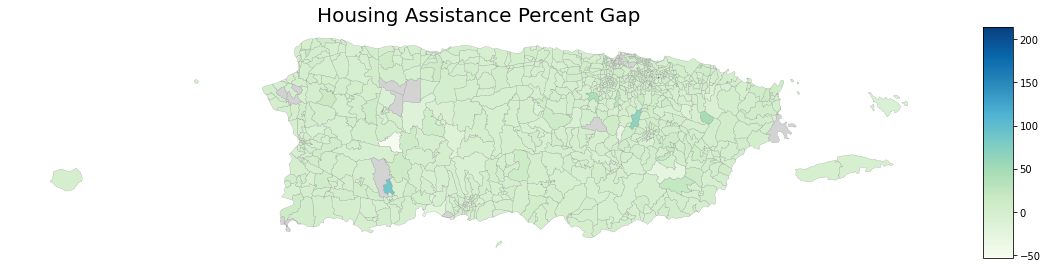

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Vislualize
fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

census_tract_percent_gap_map.plot(column='percent_gap', edgecolor='grey', linewidth=.2, 
                                    ax=ax, legend=True, cax=cax, cmap='GnBu', missing_kwds={'color': 'lightgrey'})

# title and layout
ax.set_title('Housing Assistance Percent Gap', fontsize=20)
ax.axis('off')
plt.tight_layout()